In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import lightgbm as lgb

import coursera_competition_udfs as udf
import gc
from scipy.stats import percentileofscore
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestRegressor

# Load data

- First, we aggregate sales data by month, where for each month we create a grid of all the shops and items that have sales in that month. (Note that all other combinations would yield rows or columns of zeroes, but this introduces survivor bias). We then stack monthly time series data for all such shop-item pairs.
- Then we created lagged sales of the 3 types of sales data: previous monthly sales of the shop_item pair, and previous monthly sales of the shop, and item, for different lag periods
- Finally we merge lagged sales data with other information, such as seasonality features
- Note that train and test data are concatenated and features generated altogether (ok for Kaggle and more convenient)

In [2]:
all_sales = udf.load_all_monthly_sales()

column added: target
column added: target_shop
column added: target_item
Calculating shift by 1 periods
Calculating shift by 2 periods
Calculating shift by 3 periods
Calculating shift by 6 periods
Calculating shift by 12 periods
Deleting date_block_num < 12 from data


In [3]:
# pkl_name = './' + 'monthly_sales_grid_lag_1_2_3_6_12_seasonality_items_shops' + '.pkl'

# all_sales = pd.read_pickle(pkl_name)

In [4]:
all_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 29 columns):
date_block_num             int64
item_id                    int64
shop_id                    int64
target                     float64
target_lag_1               int64
target_item_lag_1          int64
target_shop_lag_1          int64
target_lag_2               int64
target_item_lag_2          int64
target_shop_lag_2          int64
target_lag_3               int64
target_item_lag_3          int64
target_shop_lag_3          int64
target_lag_6               int64
target_item_lag_6          int64
target_shop_lag_6          int64
target_lag_12              int64
target_item_lag_12         int64
target_shop_lag_12         int64
target_shop_zero           bool
target_item_zero           bool
target_shop_recent_zero    bool
target_item_recent_zero    bool
december                   bool
Q1                         bool
Q4                         bool
item_category_id           int64
i

In [5]:
# sanity check: no missing attributes other than test set label
nul_cols = all_sales.isnull().sum()
nul_cols[nul_cols>0]

target    214200
dtype: int64

# Prepare data for model training

In [6]:
# encode categorical cols
categ_cols = ['item_id', 'shop_id', 'item_category_id', 'item_category_group', 'shop_city']
all_sales = udf.label_encode_categ_cols(all_sales, categ_cols)

label encoding item_id and saving to enc_item_id.pickle
label encoding shop_id and saving to enc_shop_id.pickle
label encoding item_category_id and saving to enc_item_category_id.pickle
label encoding item_category_group and saving to enc_item_category_group.pickle
label encoding shop_city and saving to enc_shop_city.pickle


In [7]:
# training and validation data, with all possible features
X_train, X_val, y_train_clip, y_val_clip = udf.train_test_split_by_month(all_sales, clip_train=True, clip_test=True)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in train data are clipped to [0, 20]
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:423: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train[label] = df_train[label].clip(0, 20)
/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 28


In [8]:
# # training and validation data, with all possible features
# X_train, X_val, y_train, y_val = udf.train_test_split_by_month(all_sales)

# Model selection

## LGBM

### Training lgbm with original target values

In [8]:
# model training with early stopping
lgb_params = {
               'max_depth': 8,  # reduce to increase regularization
               'bagging_fraction': 0.6, 
               'feature_fraction': 0.7, # reduce to increase regularization
               'min_data_in_leaf': 1000, 
               'learning_rate': 0.01, 
               'bagging_freq':1,
                'objective': 'regression', 
                'metric': 'rmse',
               'nthread':4, # parallel computation
               'verbose':0
              }
num_rounds = 2500

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
evals_result = {}  # to record eval results for plotting

bst = lgb.train(lgb_params, lgb_train, num_rounds, valid_sets=[lgb_train, lgb_val],
                early_stopping_rounds=20,
                keep_training_booster=True,
                categorical_feature=['item_id', 'shop_id', 'item_category_id', 'item_category_group', 'shop_city'],
                evals_result=evals_result, verbose_eval=20)

/home/johanna/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_group', 'item_category_id', 'item_id', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/johanna/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_group', 'item_category_id', 'item_id', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/johanna/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 3.39001	valid_1's rmse: 5.25785
[40]	training's rmse: 3.28162	valid_1's rmse: 5.19789
[60]	training's rmse: 3.19793	valid_1's rmse: 5.15259
[80]	training's rmse: 3.13252	valid_1's rmse: 5.11646
[100]	training's rmse: 3.08078	valid_1's rmse: 5.09349
[120]	training's rmse: 3.03903	valid_1's rmse: 5.07404
[140]	training's rmse: 3.00536	valid_1's rmse: 5.05462
[160]	training's rmse: 2.9773	valid_1's rmse: 5.04352
[180]	training's rmse: 2.95395	valid_1's rmse: 5.03237
[200]	training's rmse: 2.9361	valid_1's rmse: 5.02252
[220]	training's rmse: 2.92077	valid_1's rmse: 5.0132
[240]	training's rmse: 2.90779	valid_1's rmse: 5.00557
[260]	training's rmse: 2.89704	valid_1's rmse: 4.9989
[280]	training's rmse: 2.88718	valid_1's rmse: 4.99323
[300]	training's rmse: 2.87922	valid_1's rmse: 4.98794
[320]	training's rmse: 2.87201	valid_1's rmse: 4.98491
[340]	training's rmse: 2.86585	valid_1's rmse: 4.98097
[360]	train

Previously result with 'max_depth': 8
Early stopping, best iteration is:
[2075]	training's rmse: 2.857	valid_1's rmse: 4.82957

with 'max_depth':7: 
Early stopping, best iteration is:
[1698]	training's rmse: 2.60707	valid_1's rmse: 4.81151

However, final result after clipping is worse with 7

Plotting metrics recorded during training...


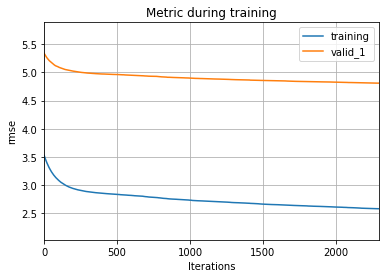

In [9]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


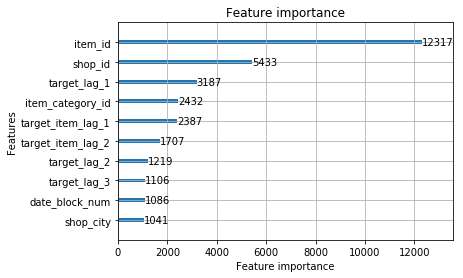

In [16]:
print('Plotting feature importances...')
ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()

In [10]:
# extract predictions of the best model for further analysis
pred_train = bst._Booster__inner_predict(data_idx=0)
pred_val = bst._Booster__inner_predict(data_idx=1)

In [13]:
# evaluate train vs val performance, no truncating in either
udf.train_val_metrics(y_train, pred_train, y_val, pred_val)

,R-squared,RMSE
train,0.468,2.577
val,0.190,4.809


In [14]:
# truncate val, not train (old comparison)
udf.train_val_metrics(y_train, pred_train, y_val, pred_val, clip_y_val=True, clip_pred_val=True)

,R-squared,RMSE
train,0.468,2.577
val,0.075,1.093


In [15]:
# truncate both train and val for fair comparison of final score
udf.train_val_metrics(y_train, pred_train, y_val, pred_val,
                      clip_y_val=True, clip_pred_val=True, clip_y_train=True, clip_pred_train=True)

,R-squared,RMSE
train,0.501,0.839
val,0.075,1.093


### Train lgbm on clipped target values

In [9]:
# model training with early stopping
lgb_params = {
               'max_depth': 8,  # reduce to increase regularization
               'bagging_fraction': 0.6, 
               'feature_fraction': 0.7, # reduce to increase regularization
               'min_data_in_leaf': 1000, 
               'learning_rate': 0.01, 
               'bagging_freq':1,
                'objective': 'regression', 
                'metric': 'rmse',
               'nthread':4, # parallel computation
               'verbose':0
              }
num_rounds = 2500

lgb_train_clip = lgb.Dataset(X_train, label=y_train_clip)
lgb_val_clip = lgb.Dataset(X_val, label=y_val_clip, reference=lgb_train_clip)
evals_result_clip = {}  # to record eval results for plotting

bst_clip = lgb.train(lgb_params, lgb_train_clip, num_rounds, valid_sets=[lgb_train_clip, lgb_val_clip],
                early_stopping_rounds=20,
                keep_training_booster=True,
                categorical_feature=['item_id', 'shop_id', 'item_category_id', 'item_category_group', 'shop_city'],
                evals_result=evals_result_clip,
                verbose_eval=20)

/home/johanna/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_group', 'item_category_id', 'item_id', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/johanna/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_group', 'item_category_id', 'item_id', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/johanna/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 1.10297	valid_1's rmse: 1.08283
[40]	training's rmse: 1.03631	valid_1's rmse: 1.04726
[60]	training's rmse: 0.985781	valid_1's rmse: 1.02199
[80]	training's rmse: 0.946998	valid_1's rmse: 1.0022
[100]	training's rmse: 0.916617	valid_1's rmse: 0.990864
[120]	training's rmse: 0.892262	valid_1's rmse: 0.984559
[140]	training's rmse: 0.87362	valid_1's rmse: 0.976728
[160]	training's rmse: 0.858167	valid_1's rmse: 0.974476
[180]	training's rmse: 0.845889	valid_1's rmse: 0.972324
[200]	training's rmse: 0.836237	valid_1's rmse: 0.970468
[220]	training's rmse: 0.827845	valid_1's rmse: 0.968952
[240]	training's rmse: 0.821347	valid_1's rmse: 0.96825
[260]	training's rmse: 0.815877	valid_1's rmse: 0.967424
Early stopping, best iteration is:
[257]	training's rmse: 0.816609	valid_1's rmse: 0.967257


In [10]:
bst_clip.save_model('lgbm_bst_model_clip.txt', num_iteration=bst_clip.best_iteration)

Plotting metrics recorded during training...


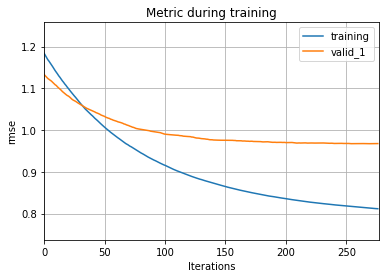

In [11]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result_clip)
plt.show()

Plotting feature importances...


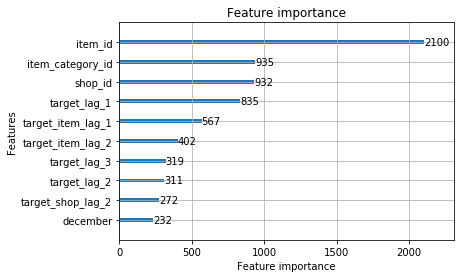

In [13]:
print('Plotting feature importances...')
ax = lgb.plot_importance(bst_clip, max_num_features=10)
plt.show()

In [11]:
# extract predictions of the best model for further analysis
pred_train = bst_clip._Booster__inner_predict(data_idx=0)
pred_val = bst_clip._Booster__inner_predict(data_idx=1)

# evaluate train vs val performance, no truncating in either
print('Evaluation on original target values:\n',
      udf.train_test_metrics(y_train_clip, pred_train, y_val_clip, pred_val)
     )

# truncate both train and val for fair comparison of final score
print('\nEvaluation on clipped target values:\n', 
      udf.train_test_metrics(y_train_clip, pred_train, y_val_clip, pred_val,
                      clip_train=True, clip_test=True)
     )

Evaluation on original target values:
        R-squared   RMSE
train      0.533  0.812
val        0.275  0.968

Evaluation on clipped target values:
        R-squared   RMSE
train      0.533  0.812
val        0.275  0.968


## Analyze errors

In [243]:
val_err = pd.DataFrame({
    'y_val': y_val,
    'pred_val': pred_val,
    'e_val': y_val - pred_val,
    'true_zero': y_val==0,
    'pred_zero': pred_val==0}).reset_index()

In [244]:
val_err.head()

,index,y_val,pred_val,e_val,true_zero,pred_zero
0,6186922,1.0,0.233144,0.766856,False,False
1,6186923,1.0,0.531189,0.468811,False,False
2,6186924,2.0,0.411870,1.588130,False,False
3,6186925,1.0,0.256927,0.743073,False,False
4,6186926,1.0,0.407339,0.592661,False,False


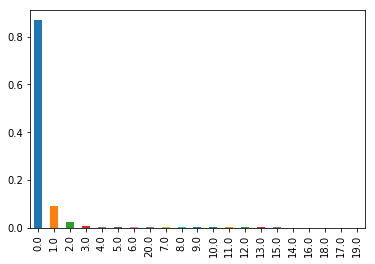

In [196]:
val_err['y_val'].value_counts(normalize=True).plot(kind='bar');

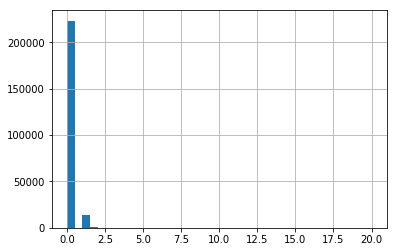

In [207]:
val_err['post_val'].hist(bins=40)

In [198]:
sum(val_err['post_val']<1)/val_err.shape[0]

0.9374443679357775

In [199]:
sum(val_err['y_val']<1)/val_err.shape[0]

0.8678644005172732

In [201]:
val_err['y_val'].describe()

count    238172.000000
mean          0.258565
std           1.136157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: y_val, dtype: float64

In [202]:
val_err['post_val'].describe()

count    238172.000000
mean          0.076168
std           0.421836
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: post_val, dtype: float64

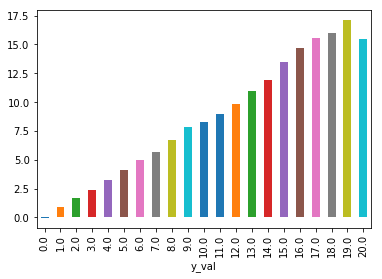

In [203]:
val_err.groupby('y_val')['e_val'].mean().plot(kind='bar');

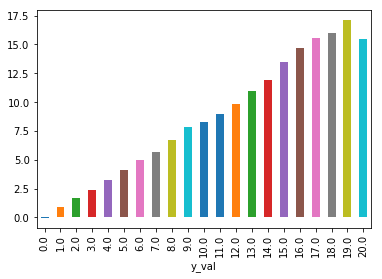

In [204]:
val_err.groupby('y_val')['e_val'].mean().plot(kind='bar');

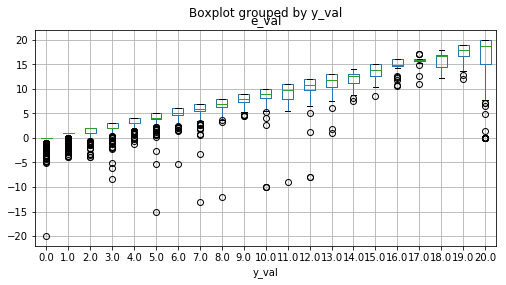

In [205]:
val_err.boxplot(column='e_val', by='y_val', figsize=(8,4));

In [206]:
confusion_matrix(val_err['true_zero'], val_err['pred_zero'])

array([[  7618,  23853],
       [  7281, 199420]])

### Where does mse come from

In [325]:
def make_df_residuals(y_true, y_pred, bins=None):
    ssr = y_true
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).reset_index(drop=True)

    df['res'] = df['y_true'] - df['y_pred']
    df['sq_res'] = df['res']**2

    df['true_zero'] = (df['y_true']==0)
    df['pred_zero'] = (df['y_pred']==0)

    if bins is None:
        bins = np.arange(21)
        if df['y_pred'].min()<0:
            bins = np.insert(bins, 0, df['y_pred'].min())        
        if df['y_pred'].max()>20:
            bins = np.append(bins, df['y_pred'].max())
    df['pred_bin'] = pd.cut(df['y_pred'], bins, right=False, duplicates='drop')
    return df

In [326]:
err_post = make_df_residuals(y_val, post_val)

In [327]:
err_pred = make_df_residuals(y_val, pred_val)

In [328]:
err_pred.head()

,y_true,y_pred,res,sq_res,true_zero,pred_zero,pred_bin
0,1.0,0.233144,0.766856,0.588068,False,False,"[0.0, 1.0)"
1,1.0,0.531189,0.468811,0.219784,False,False,"[0.0, 1.0)"
2,2.0,0.411870,1.588130,2.522157,False,False,"[0.0, 1.0)"
3,1.0,0.256927,0.743073,0.552157,False,False,"[0.0, 1.0)"
4,1.0,0.407339,0.592661,0.351248,False,False,"[0.0, 1.0)"


In [331]:
bins_pred = [pred_val.min(), 0.5, 1, 2, 5, 10, 20, pred_val.max()]

err_pred = make_df_residuals(y_val, pred_val, bins_pred)

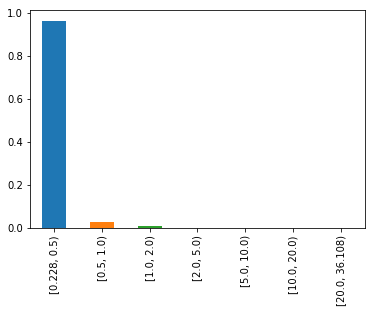

In [335]:
err_pred.loc[err_pred['y_true']==0, 'pred_bin'].value_counts(normalize=True).sort_index().plot(kind='bar');

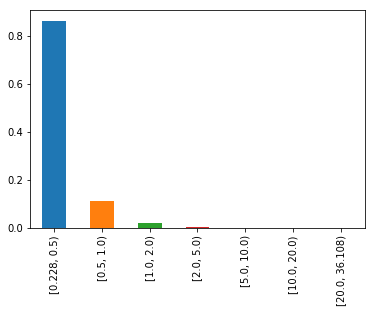

In [336]:
err_pred.loc[err_pred['y_true']==1, 'pred_bin'].value_counts(normalize=True).sort_index().plot(kind='bar');

In [350]:
sum(y_val==0)/len(y_val)

0.8678644005172732

In [354]:
err_pred['y_pred'].quantile(0.868)

0.3504645948549393

In [353]:
err_pred['y_pred'].describe()

count    238172.000000
mean          0.315517
std           0.478106
min           0.227658
25%           0.229639
50%           0.260337
75%           0.301444
max          36.108089
Name: y_pred, dtype: float64

In [340]:
err_pred.pred_bin.unique()

[[0.228, 0.5), [0.5, 1.0), [1.0, 2.0), [5.0, 10.0), [2.0, 5.0), [20.0, 36.108), NaN, [10.0, 20.0)]
Categories (7, interval[float64]): [[0.228, 0.5) < [0.5, 1.0) < [1.0, 2.0) < [2.0, 5.0) < [5.0, 10.0) < [10.0, 20.0) < [20.0, 36.108)]

In [347]:
err_pred['pred_bin'][0]

Interval(0.228, 0.5, closed='left')

In [348]:
err_pred.loc[err_pred['pred_bin']==Interval(0.228, 0.5, closed='left'), 'y_true']

NameError: name 'Interval' is not defined

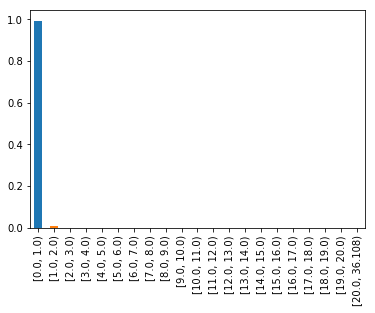

In [322]:
err_pred.loc[err_pred['y_true']==0, 'pred_bin'].value_counts(normalize=True).sort_index().plot(kind='bar');

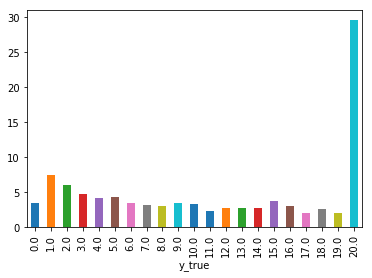

In [269]:
(100*err_post.groupby('y_true')['sq_res'].sum()/err_post['sq_res'].sum()).plot(kind='bar');

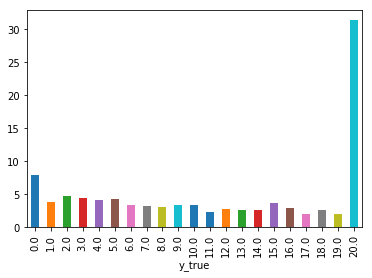

In [270]:
(100*err_pred.groupby('y_true')['sq_res'].sum()/err_pred['sq_res'].sum()).plot(kind='bar');

In [275]:
err_pred.loc[err_pred['y_true']==0, 'y_pred'].describe()

count    206701.000000
mean          0.283115
std           0.125323
min           0.227658
25%           0.229639
50%           0.251268
75%           0.294597
max          23.336065
Name: y_pred, dtype: float64

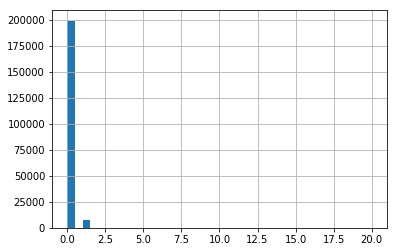

In [274]:
err_post.loc[err_post['y_true']==0, 'y_pred'].hist(bins=40);

In [238]:
val_err.loc[val_err['y_val']==20, 'post_val'].shape

(261,)

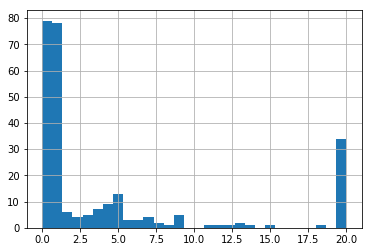

In [237]:
val_err.loc[val_err['y_val']==20, 'post_val'].hist(bins=30)

Observation: 
- our model consistently underpredicts the true sales
- the prediction error is increasing in the true sales, i.e. we are really bad at predicting positive sales.
- in fact, our model never predicts zero, whereas the true target is predominantly zero. Scores hover above 0.22. 
- the vast majority of predictions are between 0 and 1. Consider rounding and/or doing regression?

It is hard to predict well for several reasons:
- the true values are mostly zero. akin to unbalanced problem?
- the true values are integers whereas the predictions, treating it as a regression problem, are real
- it is hard to predict exactly zero. 

The high RMSE on the validation set is driven by:
- wrong predictions of the ones with true value 20, which are most often predicted close to zero. This is due to the rmse property that high 
- rounding the predictions between 0 and 1 didn't help much in terms of mse becuase it decreased the residuals for true values of 0 but increased the ones for 1. could consider shifting the threshold 

### RF on numeric features
trains a while

In [13]:
rf = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=50)
udf.fit_eval_model(rf, X_train_num, X_val_num, y_train, y_val)

KeyboardInterrupt: 

In [12]:
rf_model = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=50)
rf_model.fit(X_train_num, y_train)
udf.eval_model_pred(rf_model, X_train_num, X_val_num, y_train, y_val)

       R-squared   RMSE
train      0.477  2.555
val        0.166  1.038


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

# Predict on test set

In [18]:
# training and validation data, with all possible features, clipped target
all_train, all_test, y_all_train, y_all_test = udf.train_test_split_by_month(all_sales, test_start=34, 
                                                                                       clip_train=True, clip_test=True)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Test data: date_block_num [34]
target values in train data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:423: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train[label] = df_train[label].clip(0, 20)


Number of observations in train: 6425094
Number of observations in test: 214200
Number of attributes: 28


In [19]:
model_select = lgb.Booster(model_file='lgbm_bst_model_clip.txt')  #init model
pred_test = model_select.predict(all_test)

In [20]:
pred_submit = all_test[['item_id', 'shop_id']].copy().reset_index(drop=True)
pred_submit['target'] = pred_test

# inverse the item and shop ids
pred_submit = udf.inverse_label_encode_categ_cols(pred_submit, ['item_id', 'shop_id'])

inverse label encoding item_id from file enc_item_id.pickle
inverse label encoding shop_id from file enc_shop_id.pickle


/home/johanna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/johanna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
test_data = udf.load_test_data()

#### mismatch between shop-item pairs in test and submit?! 

In [23]:
pred_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
item_id    214200 non-null int64
shop_id    214200 non-null int64
target     214200 non-null float64
dtypes: float64(1), int64(2)
memory usage: 4.9 MB


In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [25]:
pred_submit['item_id'].nunique(), pred_submit['shop_id'].nunique()

(5100, 42)

In [26]:
test_data['item_id'].nunique(), test_data['shop_id'].nunique()

(5100, 42)

In [27]:
submit_shops = set(pred_submit['shop_id'])

In [28]:
test_shops = set(test_data['shop_id'])

In [29]:
submit_shops-test_shops

set()

In [30]:
test_shops - submit_shops

set()

### Create submission file 

In [31]:
# create submission file with IDs from test data
submit = (pd.merge(test_data, pred_submit, how='left', on=['shop_id', 'item_id'])
              .rename(columns={'target': 'item_cnt_month'})
                  .drop(columns=['shop_id', 'item_id'])
          )

In [32]:
submit.shape

(214200, 2)

In [34]:
submit.isnull().sum()

ID                0
item_cnt_month    0
dtype: int64

In [35]:
submit.to_csv('submission_lgbm_lags_and_id_features.csv', index=False)
# yields public leaderboard score of 